In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

import pickle
import json
import sys
import numpy.random as random
sys.path.append("../../")

import time 

from src.online_prediction.OnlineDataProcessor.dataProcessor import DataProcessor
from src.context_aware.models import createModel
from src.context_aware.config.configs import MetaConfig, ModelConfig

In [2]:
rawDatasetFolder = "../../data/raw"
configPath = "../config/combined_flows_forward.json"
modelFolder = "../../data/models/context_aware"
trafficDataFolder = "../../data/processed/dpdr"
verbose = True

In [3]:
config = json.load(open(configPath))
name = config.get("NAME")
len_window = config.get("LEN_WINDOW")
dim_data =  len(config.get("CONTEXT_IDXS"))

In [4]:
csv_data = pd.read_csv(f"{trafficDataFolder}/{name}.csv")
print(csv_data.head(5))

with open(f"{modelFolder}/{name}_lenWindow_{len_window}_modelConfig.pkl", "rb") as f:
    modelConfig = pickle.load(f)
with open(f"{modelFolder}/{name}_lenWindow_{len_window}_metaConfig.pkl", "rb") as f:
    metaConfig = pickle.load(f)

metaConfig.display()

model, device = createModel(modelConfig)
model.load_checkpoint(f"{modelFolder}/{name}_lenWindow_{len_window}.pth")

       Time  Transmition Flags         0         1         2         3  \
0  731.0121                1.0  0.175745  1.018283 -0.231599  0.187127   
1  731.0146                0.0  0.175745  1.018283 -0.231599  0.187127   
2  731.0167                1.0  0.176268  1.005552 -0.233117  0.189553   
3  731.0397                0.0  0.176268  1.005552 -0.233117  0.189553   
4  731.0412                1.0  0.181416  0.989107 -0.236493  0.196212   

          4         5         6         7         8         9        10  \
0  1.033916 -0.355461  0.156312  1.031574 -0.380128  0.089013  1.097219   
1  1.033916 -0.355461  0.156312  1.031574 -0.380128  0.089013  1.097219   
2  1.019908 -0.357190  0.160393  1.020453 -0.383278  0.094699  1.089027   
3  1.019908 -0.357190  0.160393  1.020453 -0.383278  0.094699  1.089027   
4  1.002381 -0.360770  0.168533  1.005391 -0.387992  0.104753  1.076550   

         11  
0 -0.262149  
1 -0.262149  
2 -0.264705  
3 -0.264705  
4 -0.268744  
MetaConfig:
  dim_da

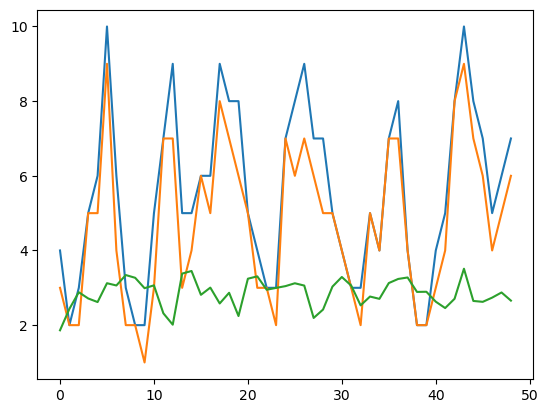

In [5]:
dataProcesor = DataProcessor(metaConfig)

traffic_recieved_list = []
traffic_predicted_list = []
traffic_generated_list = []
transmission_list = []
count = 1
N_count = 1000
last_time = time.time()
while True:
    if time.time() - last_time > metaConfig.Ts:
        transmission = csv_data.iloc[count, 1]
        data_point = csv_data.iloc[count, 2:].values
      
        if int(transmission) == 1:
            dataProcesor.add_data_point(data_point)
        last_time = time.time()

        transmission_list.append(transmission)
        if count % metaConfig.window_length == 0:
            context, last_trans_sources, context_no_smooth, debugs = dataProcesor.get_window_features()
            traffic_predicted = model.inference(context, last_trans_sources, context_no_smooth)
            (flags, timestamps_bin) = debugs
            traffic_recieved_list.append(np.sum(flags))
            traffic_generated_list.append(np.sum(transmission_list[-metaConfig.window_length:]))
            traffic_predicted_list.append(traffic_predicted)
        count += 1
    
    if count >= N_count:
        break

traffic_recieved_list = np.array(traffic_recieved_list).reshape(-1)
traffic_generated_list = np.array(traffic_generated_list).reshape(-1)
traffic_predicted_list = np.array(traffic_predicted_list).reshape(-1)


plt.plot(traffic_generated_list)
plt.plot(traffic_recieved_list)
plt.plot(traffic_predicted_list)
plt.show()